In [1]:
# Dataset:
# https://www.kaggle.com/datasets/mssmartypants/rice-type-classification

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split


In [4]:
# ============================
# 1. Dataset and Preprocessing
# ============================

class RiceDataset(Dataset):
    def __init__(self, df, scaler=None, fit_scaler=True):
        self.X = df.drop(columns=['Class']).values.astype(np.float32)
        self.y = df['Class'].values.astype(np.float32)

        if scaler is None:
            self.scaler = StandardScaler()
        else:
            self.scaler = scaler

        if fit_scaler:
            self.X = self.scaler.fit_transform(self.X)
        else:
            self.X = self.scaler.transform(self.X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [5]:
# ============================
# 2. Neural Network Model
# ============================

class RiceClassifier(nn.Module):
    def __init__(self, input_dim):
        super(RiceClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [6]:
# ============================
# 3. Training & Evaluation
# ============================

def train_model(model, train_loader, val_loader, epochs=30, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for X_val, y_val in val_loader:
                outputs = model(X_val).squeeze()
                loss = criterion(outputs, y_val)

                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_correct += (preds == y_val).sum().item()
                val_total += y_val.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


In [7]:
# ============================
# 4. Plotting
# ============================

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Val Loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(history['train_acc'], label='Train Acc')
    ax[1].plot(history['val_acc'], label='Val Acc')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()


In [8]:
# ============================
# 5. Inference Function
# ============================

def infer(model, scaler, raw_input):
    model.eval()
    X_scaled = scaler.transform([raw_input])
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    with torch.no_grad():
        output = model(X_tensor).item()
    return 1 if output > 0.5 else 0


In [9]:
# ============================
# Example Usage
# ============================
df = pd.read_csv('./rice-type-classification.csv')
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [10]:
df = df.drop(['id'], axis=1)
df.shape

(18185, 11)

In [11]:
full_dataset = RiceDataset(df)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


Epoch 1/10 - Loss: 0.0901, Acc: 0.9770, Val Loss: 0.0404, Val Acc: 0.9871
Epoch 2/10 - Loss: 0.0330, Acc: 0.9891, Val Loss: 0.0396, Val Acc: 0.9876
Epoch 3/10 - Loss: 0.0319, Acc: 0.9896, Val Loss: 0.0401, Val Acc: 0.9860
Epoch 4/10 - Loss: 0.0312, Acc: 0.9899, Val Loss: 0.0388, Val Acc: 0.9874
Epoch 5/10 - Loss: 0.0303, Acc: 0.9900, Val Loss: 0.0388, Val Acc: 0.9871
Epoch 6/10 - Loss: 0.0297, Acc: 0.9897, Val Loss: 0.0397, Val Acc: 0.9876
Epoch 7/10 - Loss: 0.0293, Acc: 0.9900, Val Loss: 0.0396, Val Acc: 0.9882
Epoch 8/10 - Loss: 0.0293, Acc: 0.9900, Val Loss: 0.0387, Val Acc: 0.9871
Epoch 9/10 - Loss: 0.0290, Acc: 0.9898, Val Loss: 0.0392, Val Acc: 0.9879
Epoch 10/10 - Loss: 0.0289, Acc: 0.9901, Val Loss: 0.0389, Val Acc: 0.9876


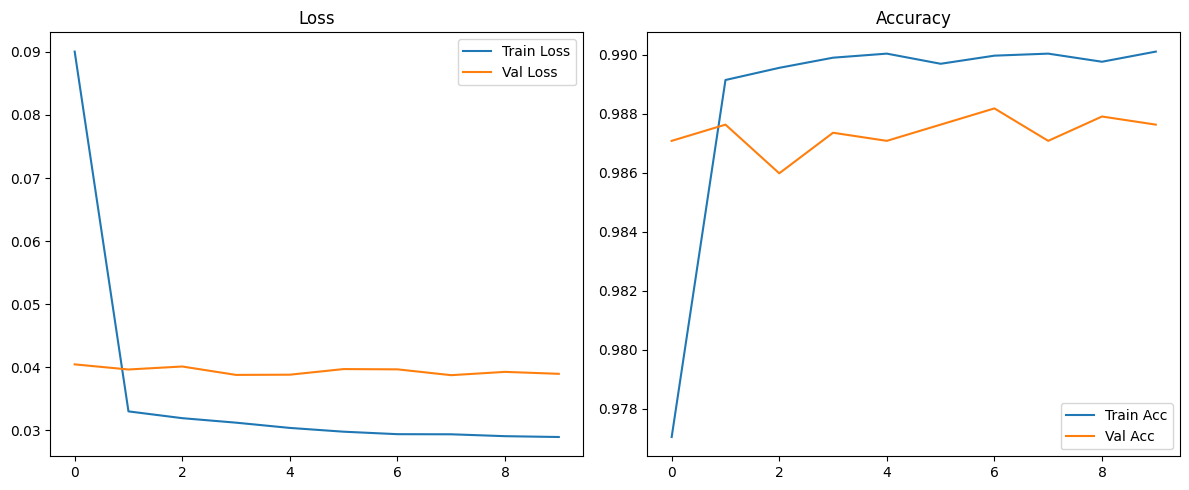

In [13]:
model = RiceClassifier(input_dim=10)

history = train_model(model, train_loader, val_loader, epochs=10)
plot_history(history)


In [14]:
example_input = [3121.0, 180.2, 120.4, 0.7, 3200.0, 63.2, 0.85, 450.2, 0.76, 1.5]
prediction = infer(model, full_dataset.scaler, example_input)
print("Predicted Class:", "Jasmine" if prediction else "Gonen")


Predicted Class: Jasmine


In [15]:
def compute_permutation_importance(model, subset_dataset, feature_names, scaler, n_repeats=5):
    model.eval()

    # Extract original dataset + indices from the Subset
    base_dataset = subset_dataset.dataset
    indices = subset_dataset.indices

    X = scaler.transform(base_dataset.X[indices])
    y = base_dataset.y[indices]

    baseline_preds = (model(torch.tensor(X, dtype=torch.float32)).squeeze().detach().numpy() > 0.5).astype(int)
    baseline_accuracy = (baseline_preds == y).mean()

    importances = []
    for col in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, col])

            preds = (model(torch.tensor(X_permuted, dtype=torch.float32)).squeeze().detach().numpy() > 0.5).astype(int)
            acc = (preds == y).mean()
            scores.append(baseline_accuracy - acc)
        importances.append(np.mean(scores))

    # Display
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(importance_df)

    importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(8, 6))
    plt.title('Permutation Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


           Feature  Importance
8        Roundness    0.003354
5    EquivDiameter    0.000275
7        Perimeter    0.000275
9     AspectRation    0.000275
6           Extent    0.000165
0             Area    0.000000
1  MajorAxisLength    0.000000
2  MinorAxisLength    0.000000
4       ConvexArea    0.000000
3     Eccentricity   -0.005169


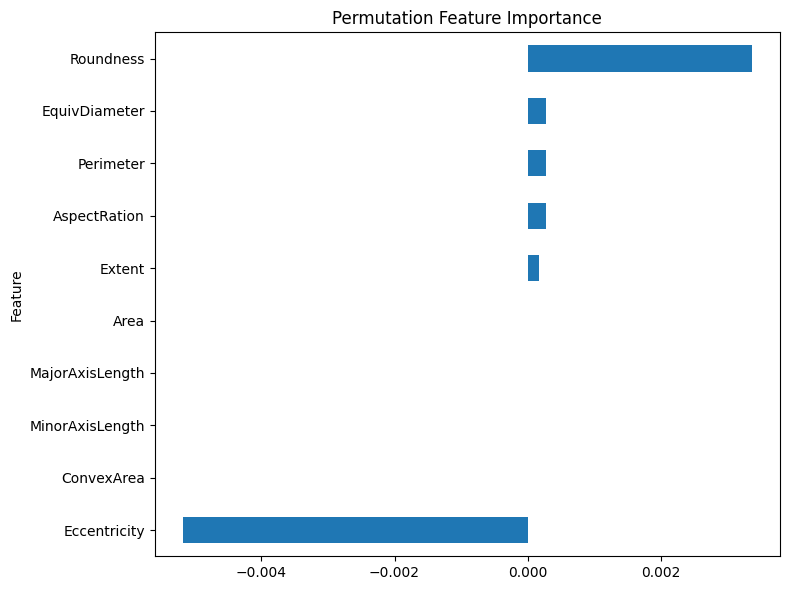

In [16]:
feature_names = df.drop(columns=['Class']).columns.tolist()
compute_permutation_importance(model, val_dataset, feature_names, full_dataset.scaler)


In [17]:
"""
Feature	        Insight
Roundness	    ✅ Strong positive importance — the model heavily relies on this feature.
Eccentricity	🚨 Slightly negative importance — the model does worse with this feature intact. Could be noisy or misleading.
AspectRation	💡 Weak positive effect — it helps a little, but not decisive.
All others	    ❌ Have near-zero or no measurable impact when permuted — either redundant or not useful for this model.
""";